<a href="https://colab.research.google.com/github/LuisDLCP/ProyectoFinal_MineriaDatos/blob/main/0)Remove_background.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Remove Image Background with DeepLabV3 Image Segmentation

---

[Github](https://github.com/eugenesiow/practical-ml/blob/master/notebooks/Remove_Image_Background_DeepLabV3.ipynb) | More Notebooks @ [eugenesiow/practical-ml](https://github.com/eugenesiow/practical-ml)

---

Notebook to remove the image background from a profile photo and to either export the transparent `.png` or to add in a custom background. It's great for making a nice profile image. The use case is inspired by paid online resources like [remove.bg](https://www.remove.bg/) or paid apps like [PhotoScissors](https://photoscissors.com/).

The [model used](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/) is the pre-trained `deeplabv3_resnet101` - a Deeplabv3 model with a ResNet-101 backbone. It was trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

The notebook is structured as follows:
* Setting up the Environment
* Getting Data
* Using the Model (Running Inference)

# Setting up the Environment

#### Dependencies and Runtime

If you're running this notebook in Google Colab, all the dependencies are already installed and we don't need the GPU for this particular example. 

If you decide to run this on many (>thousands) images and want the inference to go faster though, you can select `Runtime` > `Change Runtime Type` from the menubar. Ensure that `GPU` is selected as the `Hardware accelerator`.

# Getting Data

#### Getting a Foreground and Background Image

* Foreground image: [Demis Hassabis](https://en.wikipedia.org/wiki/Demis_Hassabis), co-founder of DeepMind. From Twitter.
* Background image: A [photo of the universe](https://unsplash.com/photos/eS7HrvG0mcA) by Nathan Anderson. From Unsplash.

We'll save these images to our local storage and view a preview of them in our notebook.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!ls

con_mask823.png  drive	sample_data


In [ ]:
pathInputFiles = "./drive/MyDrive/Master_program/AprendizajeAutomatico/Proyecto_final/DataSet/etiquetados/sin_mask/"
!ls $pathInputFiles

ls: cannot access './drive/MyDrive/Master_program/AprendizajeAutomatico/Proyecto_final/DataSet/etiquetados/sin_mask/': No such file or directory


In [ ]:
pathOutputFiles = "./drive/MyDrive/Master_program/AprendizajeAutomatico/Proyecto_final/DataSet/filtrado2/sin_mask/"
!ls $pathOutputFiles

In [ ]:
# Cantidad archivos entrada 
inputFiles = glob(pathInputFiles+"*")
len(inputFiles)

846

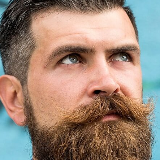

In [ ]:
import cv2
from urllib.request import urlretrieve
from google.colab.patches import cv2_imshow

# display the images in the notebook
file_test = inputFiles[0]
cv2_imshow(cv2.imread(file_test))


# Using the Model (Running Inference)

First we define a few functions that we will use to remove the background of the profile image of Demis. 

* `load_model` - Loads the pre-trained DeepLabV3-ResNet101 model from torchhub.
* `make_transparent_foreground` - Given the original image and a mask, it creates the transparent foreground image by adding in an alpha channel to the original image
* `remove_background` - Our main function for removing the background. First it creates a binary mask (a mask of the foreground and background using the DeepLab model). Then, it calls `make_transparent_foreground` to make a transparent foreground image using the binary mask.

In [ ]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

We execute the `load_model` function to download and load the model, note that this only needs to be done once when running for multiple images.

Then we call the `remove_background` function on Demis's profile image. This function returns 2 `numpy` arrays, the former, `foreground` is of the transparent foreground image with an alpha channel and the later, `bin_mask` is the binary mask detected using the DeepLab model.

Finally, we plot/display the `bin_mask` array returned. We see the silhouette of Demis showing that the DeepLab model has correctly segmented the image. 

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.6.0


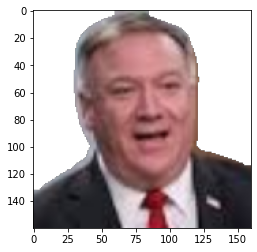

In [ ]:
import numpy as np
from glob import glob

inputFiles = glob(pathInputFiles+"*")

deeplab_model = load_model()
for file_i in inputFiles:
  foreground, bin_mask = remove_background(deeplab_model, file_i)
  Image.fromarray(foreground).save(pathOutputFiles + file_i.split("/")[-1])  
#plt.imshow(bin_mask)
plt.imshow(foreground)

In [ ]:
# Output files len 
outputFiles = glob(pathOutputFiles+"*")
len(outputFiles)

821

In [ ]:
pathFiltradosInputFiles = "./drive/MyDrive/Master_program/AprendizajeAutomatico/Proyecto_final/DataSet/filtrado2/con_mask/"
#!ls $pathInputFiles

In [ ]:
pathGrisesOutputFiles = "./drive/MyDrive/Master_program/AprendizajeAutomatico/Proyecto_final/DataSet/escalagrises/con_mask/"
#!ls $pathOutputFiles

In [ ]:
import cv2 as cv 
from google.colab.patches import cv2_imshow # for image display
from skimage import io
from glob import glob
inputFiltradosFiles = glob(pathFiltradosInputFiles+"*")
for file_i in inputFiltradosFiles:
  image = io.imread(file_i)
  gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  cv.imwrite(pathGrisesOutputFiles + file_i.split("/")[-1], gray_image) 


#cv2_imshow(gray_image)

Now we plot/display the `foreground` array returned. It shows the transparent foreground image of Demis with the background successfully removed. Cool! 

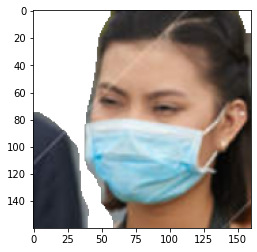

In [ ]:
plt.imshow(foreground)

We can now use PIL (the image library) to save the `foreground` numpy array that we have created to a `.png` file. We can use this image as a transparent background `.png` as it has a proper alpha channel (for transparency) now and we have removed the background.

In [ ]:
Image.fromarray(foreground).save("/content/con_mask823_2.png")

Now we write a new function to take a background file we downloaded and paste the transparent `foreground` numpy array we have created on it to superimpose them.

In [ ]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0]-final_foreground.size[0])/2
  y = (background.size[1]-final_foreground.size[1])/2
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  # put the foreground in the centre of the background
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)
  return final_image

We run the `custom_background` function we wrote and plot/display the new output image.

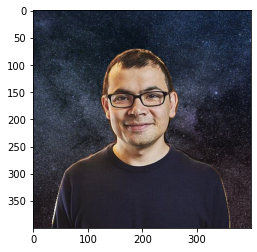

In [ ]:
final_image = custom_background('/content/background.jpg', foreground)
plt.imshow(final_image)

Finally, we save this image to our local storage with the `.save(file_location)` function. We can either download it from here or transfer it to our Google Drive.

In [ ]:
final_image.save("/content/final.jpg")

We can connect to Google Drive with the following code. You can also click the `Files` icon on the left panel and click `Mount Drive` to mount your Google Drive.

The root of your Google Drive will be mounted to `/content/drive/My Drive/`. If you have problems mounting the drive, you can check out this [tutorial](https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166).

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

You can move the output files which are saved in the `/content/` directory to your Google Drive.

In [ ]:
import shutil
shutil.move('/content/final.jpg', '/content/drive/My Drive/final.jpg')
shutil.move('/content/foreground.png', '/content/drive/My Drive/foreground.png')

More Notebooks @ [eugenesiow/practical-ml](https://github.com/eugenesiow/practical-ml) and do star or drop us some feedback on how to improve the notebooks on the [Github repo](https://github.com/eugenesiow/practical-ml/).